# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](https://giving.virginia.edu/sites/default/files/2019-02/jgi-teaser-image.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture. 

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points. To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_codeathon_2.ipynb

# Step 1: Help Building the first UVA Landmark Dataset (10 points + 10 bonus)
As part of this codeathon, you are embarking on a large effort to collect image data of EVERY building on Grounds. Together, we are building the first complete UVA Landmark Dataset of 200 buildings (and up to 100,000 images). So far, we already has data of 18 buildings which you will use in the latter steps, but it's important to grow this dataset so that every building and landmark at UVA will be considered. You will earn 10 points for providing 100 images on different perspective / viewing angle of a UVA building of your choice. If you would like to contribute more, you may sign up for an additional building (and uploading 100 images) for 10 bonus points. Please sign up below quickly so pick your favorite as only a limited number of sign ups available for each building. Additional detail on the acquisition app will be shared with you after the sign up is completed.

> [SIGN UP HERE!](https://docs.google.com/spreadsheets/d/1O_1OE4vrmlQoouMvZ5VIrzf3VkDiVthMiXCVAkQwgzA/edit?usp=sharing)




Thank you for taking part of our movement to recognize landmarks on UVA Grounds. Your contribution is paid forward to future generation of ML students and beyond. 



In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

# Step 2: Process the  Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [2]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2021-11-23 17:27:03--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 142.250.145.95, 2a00:1450:4013:c14::5f
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|142.250.145.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media’

dataset.zip?alt=med 100%[===================>] 378.77M   247MB/s    in 1.5s    

2021-11-23 17:27:05 (247 MB/s) - ‘dataset.zip?alt=media’ saved [397174132/397174132]



In [3]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Rotunda/0000010694.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/R

In [4]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar
import tensorflow_datasets as tdfs

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150; 
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        


Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [5]:
type(train_ds)
# ex = train_ds.take(1)
# ex = ex.as_numpy_iterator()
# for c,d in tdfs.as_numpy(train_ds):
#   print(c)
#   print(d)

tensorflow.python.data.ops.dataset_ops.BatchDataset

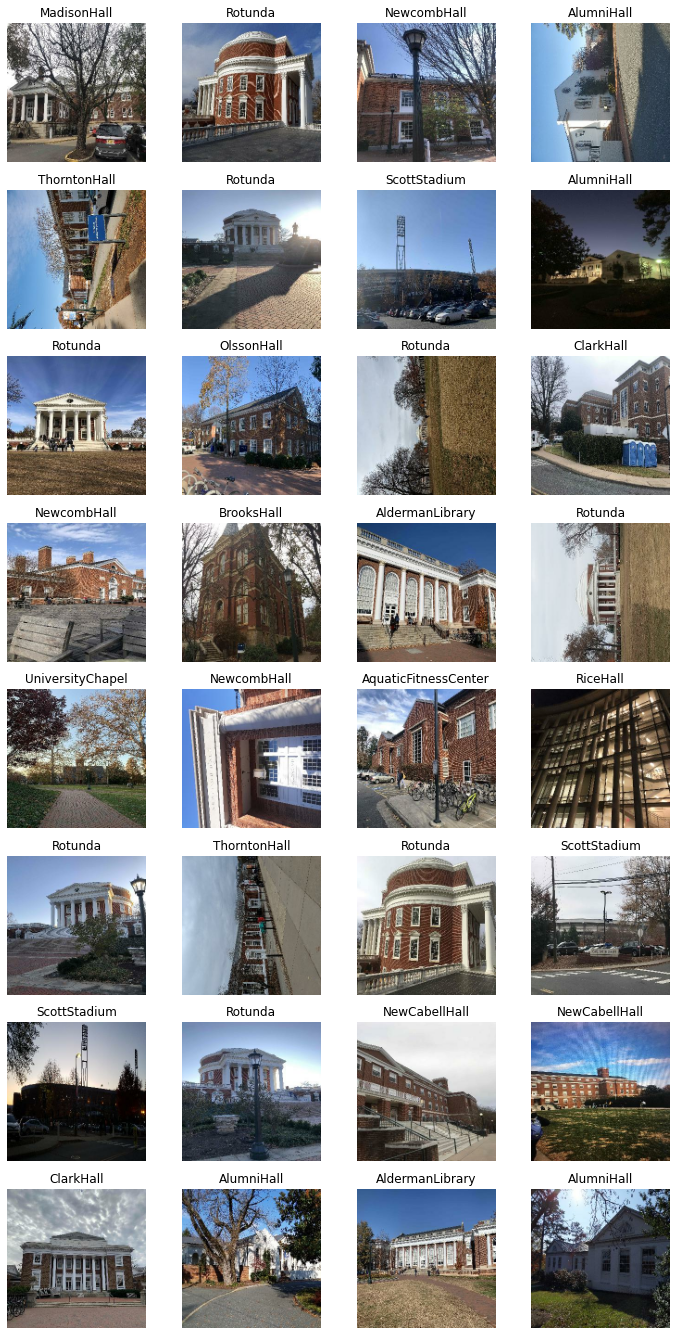

In [6]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


In [7]:
# YOUR CODE STARTS HERE

# Step 3: Create your own CNN architecture
You must design your own architecture. To get started, you may get inspiration from one in CNN notebook  (i.e. use one similar to LeNet-5 or AlexNet). You will have to report the design of the architecture:

1.   How many layers does it have? 
2.   Why do you decide on a certain number nodes per layer? 
3.   Which activation functions do you choose? 
4.   How many parameters does it has in total?

Hint: use `myModel.summary()` to learn on the layers and parameters




In [8]:
# Your code here
#x = tf.constant([-3.0, -1.0, 0.0, 1.0, 3.0], dtype=tf.float32)
#LeNet Model
#Layers = 7
#Activation functions: tanh, gelu
#We decide on a certain number of nodes so as to not have too many parameters and keep the model computationally efficient
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
tf.keras.backend.clear_session()
# myModel  = keras.models.Sequential([
#     DefaultConv2D(filters=64, kernel_size=7, input_shape=[150, 150, 3]),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=28),
#     DefaultConv2D(filters=28),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=56),
#     DefaultConv2D(filters=56),
#     keras.layers.MaxPooling2D(pool_size=2),
#     keras.layers.Flatten(),
#     keras.layers.Dense(units=28, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(units=4, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(units=1, activation='softmax'),
# ])
myModel  =keras.models.Sequential([##TODO
    keras.layers.InputLayer(input_shape=(150,150,3,)),
    keras.layers.BatchNormalization(),   
    # keras.layers.Dense(8),
    keras.layers.Conv2D(filters=50,kernel_size=2,activation='tanh', strides=1),
    keras.layers.AveragePooling2D(),
    # keras.layers.Conv2D(filters=50,kernel_size=(2,2),activation='tanh', strides=1),
    #keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters=50,kernel_size=(2,2),activation='tanh', strides=1),
    keras.layers.Flatten(),
    # keras.layers.Dense(40,activation='tanh'),
    keras.layers.Dropout(0.5),
    # keras.layers.Dense(10,activation='softmax'),
    # keras.layers.Dropout(0.5),
    keras.layers.Dense(18,activation='softmax'),
    #keras.layers.Dropout(0.25)
    #keras.layers.Dense(1)
                                    ])
# myModel.build((150,))
myModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 150, 150, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 149, 149, 50)      650       
                                                                 
 average_pooling2d (AverageP  (None, 74, 74, 50)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 50)        10050     
                                                                 
 flatten (Flatten)           (None, 266450)            0         
                                                                 
 dropout (Dropout)           (None, 266450)            0

After designing the model, you will need to train it. In order to train, you will need to pick a number of `epoch` (iteration), which `optimizer` to use (from  `keras.optimizers`), a `loss` function, and some `metrics`.

In [9]:
myEpochs =20 ##TODO
#myModel.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
myOptimizer = keras.optimizers.SGD(learning_rate=0.001)       #TODO
myLoss = keras.losses.SparseCategoricalCrossentropy() #TODO
myMetrics = keras.metrics.Accuracy(), keras.metrics.SparseCategoricalAccuracy()        #TODO keep in mind that this can be multiple metrics including at least the accuracy
tf.keras.backend.clear_session()
myModel.compile(loss= myLoss, optimizer = myOptimizer, metrics = ["accuracy"])
# train_ds_numpy = tdfs.as_numpy(train_ds)
# validation_ds_numpy = tdfs.as_numpy(validation_ds)
# feature = []
# label = []
# feature_val = []
# label_val = []
# for ex in train_ds_numpy:
#   feature_val,label_val = ex

# for les in validation_ds_numpy:
#   feature_val,label_val = les

history = myModel.fit(train_ds,epochs= myEpochs, validation_data=validation_ds)

Epoch 1/20
358/358 [==============================] - 262s 730ms/step - loss: 2.5238 - accuracy: 0.2394 - val_loss: 2.3693 - val_accuracy: 0.2884
Epoch 2/20
358/358 [==============================] - 261s 728ms/step - loss: 2.2230 - accuracy: 0.3410 - val_loss: 2.3023 - val_accuracy: 0.2958
Epoch 3/20
358/358 [==============================] - 262s 731ms/step - loss: 2.0499 - accuracy: 0.3992 - val_loss: 2.1880 - val_accuracy: 0.3504
Epoch 4/20
358/358 [==============================] - 261s 729ms/step - loss: 1.9294 - accuracy: 0.4357 - val_loss: 2.1474 - val_accuracy: 0.3581
Epoch 5/20
358/358 [==============================] - 261s 728ms/step - loss: 1.8333 - accuracy: 0.4671 - val_loss: 2.1144 - val_accuracy: 0.3780
Epoch 6/20
358/358 [==============================] - 261s 730ms/step - loss: 1.7364 - accuracy: 0.5012 - val_loss: 2.0832 - val_accuracy: 0.3924
Epoch 7/20
358/358 [==============================] - 265s 741ms/step - loss: 1.6504 - accuracy: 0.5264 - val_loss: 2.0703 -

Next, you need to create (1) a plot of training and validation `loss` and (2) a plot of training and validation `accuracy`. These plots might give you some insights about your model performance and possibility of overfitting.

Report the performance of your architecture on the validation set in a `confusion matrix`. Make comments on the performance by answering the following questiosns:
- How well do you think your architecture is doing (overall accuracy)? 
- Where did it makes mistake most? 
- Which classes can be improved?

In [10]:
from sklearn.metrics import confusion_matrix
y_pred = []
y_act = []
for x, y in validation_ds:
    temp = keras.backend.argmax(myModel.predict(x))
    for k in range(len(temp)):
      y_pred.append(temp[k])
      y_act.append(y[k])

# y_pred = np.asarray(y_pred)
# y_act = np.asarray(y_act)
print("y_pred",y_pred)
print("y_act",y_act)
confusion_matrix(y_act,y_pred)

y_pred [<tf.Tensor: shape=(), dtype=int64, numpy=3>, <tf.Tensor: shape=(), dtype=int64, numpy=12>, <tf.Tensor: shape=(), dtype=int64, numpy=12>, <tf.Tensor: shape=(), dtype=int64, numpy=12>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64, numpy=16>, <tf.Tensor: shape=(), dtype=int64, numpy=5>, <tf.Tensor: shape=(), dtype=int64, numpy=14>, <tf.Tensor: shape=(), dtype=int64, numpy=13>, <tf.Tensor: shape=(), dtype=int64, numpy=14>, <tf.Tensor: shape=(), dtype=int64, numpy=16>, <tf.Tensor: shape=(), dtype=int64, numpy=9>, <tf.Tensor: shape=(), dtype=int64, numpy=9>, <tf.Tensor: shape=(), dtype=int64, numpy=16>, <tf.Tensor: shape=(), dtype=int64, numpy=13>, <tf.Tensor: shape=(), dtype=int64, numpy=3>, <tf.Tensor: shape=(), dtype=int64, numpy=16>, <tf.Tensor: shape=(), dtype=int64, numpy=15>, <tf.Tensor: shape=(), dtype=int64, numpy=14>, <tf.Tensor: shape=(), dtype=int64, numpy=14>, <tf.Tensor: shape=(), dtype=int64, numpy=1>, <tf.Tensor: shape=(), dtype=int64

array([[ 17,   2,   0,   3,   0,   3,   2,   3,   1,   1,   1,  11,   4,
         10,  11,   1,   6,   3],
       [  0,  54,   1,   2,   0,   1,   5,   1,  11,   2,   3,   9,   4,
         10,  27,  11,   3,   4],
       [  0,   3,  50,   0,   0,   0,   1,   0,   2,   0,   1,  10,   2,
          3,   6,   3,   0,   1],
       [  0,   1,   1,  36,   1,   0,   1,   3,   4,   9,   3,   5,   7,
          7,  12,  15,  12,   1],
       [  0,   1,   0,   0,   6,   0,   0,   0,   1,   3,   2,   1,   1,
          4,   5,   0,   3,   0],
       [  0,   0,   0,   1,   4,  26,   2,   3,   7,   4,   2,   5,   5,
         10,   6,   0,   2,   3],
       [  2,   9,   1,   3,   1,   1,  57,   2,   4,   1,  14,  17,   4,
          9,  20,   8,  14,   4],
       [  1,   3,   1,   1,   0,   1,   3,   8,   3,   1,   0,  11,   4,
          1,  13,   4,   8,   3],
       [  0,   5,   4,   4,   2,   1,  14,   4,  31,   1,   6,   3,   5,
         13,  19,   8,  13,  11],
       [  3,   6,   4,  12,   2,   2,

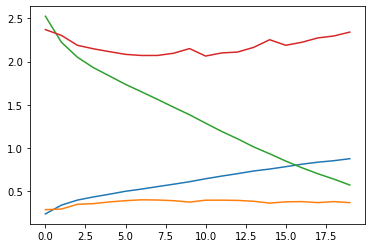

In [11]:
# Your evaluation code
from sklearn.metrics import confusion_matrix
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# Step 4: Use a Pre-trained Network with Transfer Learning
Now that you have a your own custom model and some baseline performance, let's see if you can improve the performance using transfer learning and a pre-trained model. You may use any pre-trained model EXCEPT ones that already provided such as `Xception`, `MobileNet`, `EfficientNetB6`. Keep in mind that each pre-trained model may expect a different input shape, so adjust the size of your training images accordingly.

Make sure you report the design of this architecture by answer the same questions 1-4 in Step 3.

Hint: use `ImageNet` as weights when load the pre-train network, then add a `GlobalAveragePooling2D` and an output layer with `softmax` activation.



In [12]:
# Your code here
#from tensorflow.keras.applications.resnet101 import ResNet101

model_inbuilt = keras.applications.ResNet101(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(model_inbuilt.output)
output = keras.layers.Dense(18, activation="softmax")(avg)
model = keras.models.Model(inputs=model_inbuilt.input, outputs=output)
# model_inbuilt.summary()

# model_inbuilt.compile(loss= "categorical_crossentropy", optimizer = keras.optimizers.Nadam(), metrics = ["accuracy"])
# hist1 = model_inbuilt.fit(train_ds,epochs=10,validation_data=validation_ds)
#ResNet101(weights="imagenet")

# model_concat = keras.models.Sequential()
# model_concat.add(model_inbuilt)
# model_concat.add(keras.layers.GlobalAveragePooling2D())
# model_concat.add(keras.layers.Activation('softmax'))

171458560/171446536 [==============================] - 4s 0us/step


Next, you will attempt to adapt this pre-trained model to your UVA Landmark dataset. It is recommended that you tried the two-phase training approach for your model:

1.   Phase 1: Freeze the pre-train weights and only train the top layer
2.   Phase 2: Train the entire network with much smaller learning rate (adapt the model to UVA data, but avoid destroying the transfered weights).



In [13]:
# Phase 1 code here
for layer in model_inbuilt.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_ds,
                    #steps_per_epoch=int(0.11 * 11429/ (batch_size)), #
                    validation_data=validation_ds,
                    #validation_steps=int(0.44 * 2857/ (batch_size)), #
                    epochs=5)

# model_inbuilt.trainable = False
# inputs = keras.Input(shape=(150,150,3))
# x = model_inbuilt(inputs,training=False)
# model_inbuilt.compile(loss= "categorical_crossentropy", optimizer = keras.optimizers.Nadam(), metrics = ["accuracy"])
# # x = keras.layers.GlobalAveragePooling2D()(x)
# # x = keras.layers.Flatten()(x)
# outputs = keras.layers.Dense(18)(x)
# model_concat = keras.Model(inputs,outputs)
# model_concat.compile(loss= "categorical_crossentropy", optimizer = keras.optimizers.Nadam(), metrics = ["accuracy"])
# hist_phase_1 = model_concat.fit(train_ds,epochs=10,validation_data=validation_ds)
#ypred_phase1 = model_concat.predict(test_ds)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5
358/358 [==============================] - 1456s 4s/step - loss: 39.8650 - accuracy: 0.6330 - val_loss: 13.7016 - val_accuracy: 0.7497
Epoch 2/5
358/358 [==============================] - 1477s 4s/step - loss: 7.8011 - accuracy: 0.8163 - val_loss: 9.3007 - val_accuracy: 0.7861
Epoch 3/5
358/358 [==============================] - 1479s 4s/step - loss: 4.4457 - accuracy: 0.8614 - val_loss: 8.3438 - val_accuracy: 0.8026
Epoch 4/5
358/358 [==============================] - 1486s 4s/step - loss: 3.1397 - accuracy: 0.8848 - val_loss: 7.1080 - val_accuracy: 0.8089
Epoch 5/5
358/358 [==============================] - 1489s 4s/step - loss: 2.5198 - accuracy: 0.9000 - val_loss: 6.8318 - val_accuracy: 0.8127


In [ ]:
# Phase 2 code here
for layer in model_inbuilt.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_ds,
                    #steps_per_epoch=int(0.02 * 11429/ batch_size),
                    validation_data=validation_ds,
                    #validation_steps=int(0.08 * 2857/ batch_size),
                    epochs=40)
# model_inbuilt.trainable = True
# model_concat.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Nadam(learning_rate=1e-6),metrics=["accuracy"])
# hist_phase_2 = model_concat.fit(train_ds,epochs=10,validation_data=validation_ds)
# #ypred_phase2 = model_concat.predict(test_ds)

Epoch 1/40
 90/358 [======>.......................] - ETA: 1:09:59 - loss: 11.5595 - accuracy: 0.5813

In [ ]:
y_pred_1 = []
y_act_1 = []
for x, y in validation_ds:
    temp = keras.backend.argmax(myModel.predict(x))
    for k in range(len(temp)):
      y_pred_1.append(temp[k])
      y_act_1.append(y[k])

# y_pred = np.asarray(y_pred)
# y_act = np.asarray(y_act)
print("y_pred",y_pred_1)
print("y_act",y_act_1)
confusion_matrix(y_act_1,y_pred_1)

Repeat the same reporting of performance using the confusion matrix:
- Did this pre-trained network do better overall? 
- In which class it improve the accuracy from the above model? 
- Which class still has low performance? 

Typically, your network must have a reasonable performance of at least 84% overall accuracy to be considered successful in this domain. If your network achieves a accuracy of 94% or above on the validation set, you will also recieve a 10 bonus points, so keep trying!

# Step 5: Reflection

Write at least a paragraph answering these prompts: How did your own network perform in comparison to the pre-trained one? What are the major differences between the architectures? Additionally, report on your experience implementing different models for this assignment (Was it hard/easy/fun?, from which part did you learn the most?)!